<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/autoencoder-mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder on MNIST data with TensorFlow 2

* https://blog.keras.io/building-autoencoders-in-keras.html
* https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f
* https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

dpi = 96
# dpi = 300

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

font_size=15
title_font_size=25

# https://matplotlib.org/users/colormaps.html
from matplotlib.colors import ListedColormap

colors = ['#FF0000', '#0000FF', '#FFFF00']
cmap = ListedColormap(colors) 

In [2]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [0]:
tf.random.set_seed(42)

In [5]:
!nvidia-smi

Sun Dec 29 10:28:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## MNIST data set

In [142]:
import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist

x_res = 28
y_res = 28
image_size = x_res * y_res

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

can not use 2d rep as autoencoder needs to spit out flat image

In [7]:
x_train = x_train.reshape(-1, image_size)
x_test = x_test.reshape(-1, image_size)
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [0]:
def plot_samples(x, y, n_samples=15, labels=None):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index].reshape(x_res, y_res), cmap="binary")
      if labels:
        ax.set_title("{}".format(labels[y[index]]))
      else:
        ax.set_title("{}".format(y[index]))

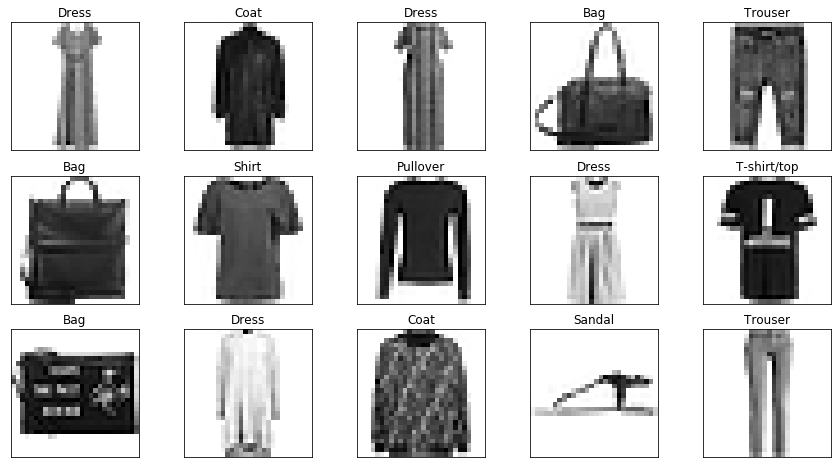

In [9]:
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9


plot_samples(x_train, y_train, labels=fashion_mnist_labels)

autoencoder using functional API

In [10]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.models import Model

encoding_dim = 32

# input_img = Input(shape=(28, 28), name='2d_input')
input_img = Input(shape=image_size, name='1d_input')
# flattened = Flatten(name='flattened_input')(input_img)
encoded = Dense(encoding_dim, activation='relu', name='encoder')(input_img)
decoded = Dense(image_size, activation='sigmoid', name='decoder')(encoded)
# reshaped = Reshape((28, 28), name='2d_output')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1d_input (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
encoder (Dense)              (None, 32)                25120     
_________________________________________________________________
decoder (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


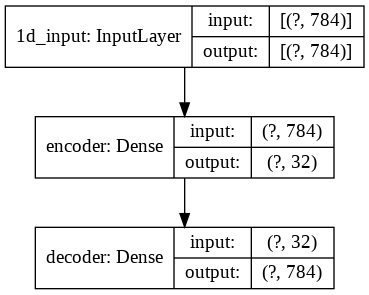

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(autoencoder, show_shapes=True, dpi=dpi)

In [12]:
%%time 

BATCH_SIZE = 256
EPOCHS = 50

# binary_crossentropy seems to encourage more sparsity all by itself
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# autoencoder.compile(optimizer='adam', loss='mse')

# we expect 0.09 for mninst and around 0.28 for fahshin mnist
history = autoencoder.fit(x = x_train,
                    y = x_train,
                    validation_data=(x_test, x_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 24us/sample - loss: 0.4145 - val_loss: 0.3425
Epoch 2/50
60000/60000 [==============================] - 1s 14us/sample - loss: 0.3263 - val_loss: 0.3186
Epoch 3/50
60000/60000 [==============================] - 1s 14us/sample - loss: 0.3104 - val_loss: 0.3073
Epoch 4/50
60000/60000 [==============================] - 1s 14us/sample - loss: 0.3014 - val_loss: 0.3000
Epoch 5/50
60000/60000 [==============================] - 1s 15us/sample - loss: 0.2956 - val_loss: 0.2957
Epoch 6/50
60000/60000 [==============================] - 1s 14us/sample - loss: 0.2919 - val_loss: 0.2926
Epoch 7/50
60000/60000 [==============================] - 1s 14us/sample - loss: 0.2894 - val_loss: 0.2909
Epoch 8/50
60000/60000 [==============================] - 1s 14us/sample - loss: 0.2878 - val_loss: 0.2894
Epoch 9/50
60000/60000 [==============================] - 1s 14us/sample - loss: 0.2868 - val_

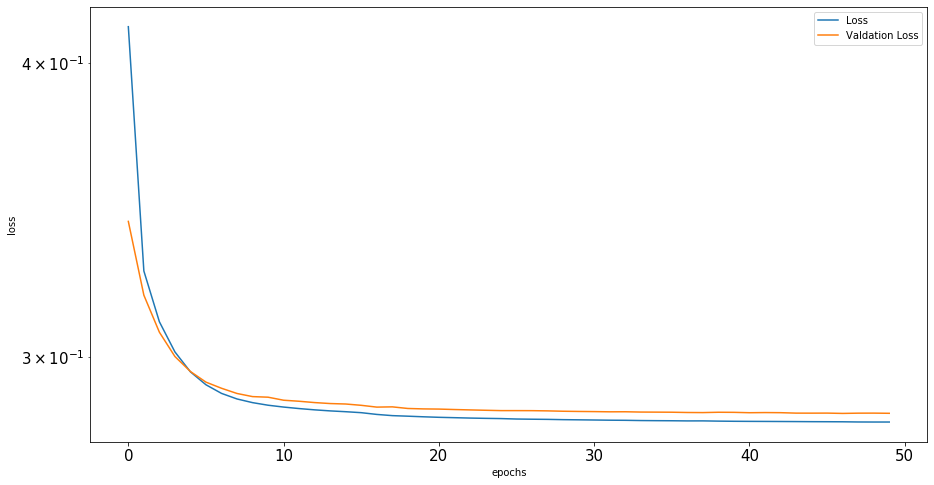

In [13]:
plt.yscale('log')

plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(["Loss", "Valdation Loss"]);

In [0]:
encoder = Model(input_img, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.get_layer('decoder')
decoder = Model(encoded_input, decoder_layer(encoded_input))

embedded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(embedded_imgs)

In [0]:
# shortcut
# x_test_pred = autoencoder.predict(x_test)
x_test_pred = decoded_imgs

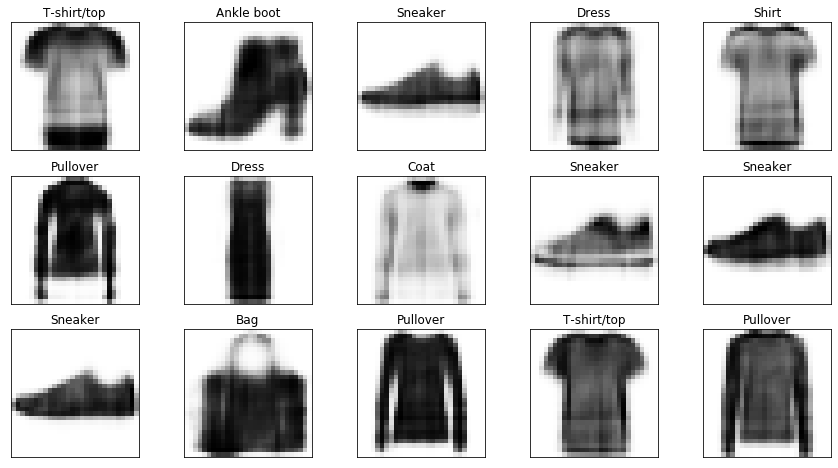

In [16]:
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)

In [0]:
def compare_samples(x, x_pred, n_samples=5):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(2, n_samples, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index].reshape(x_res, y_res), cmap="binary")
      ax = figure.add_subplot(2, n_samples, i + 1 + n_samples, xticks=[], yticks=[])
      ax.imshow(x_pred[index].reshape(x_res, y_res), cmap="binary")

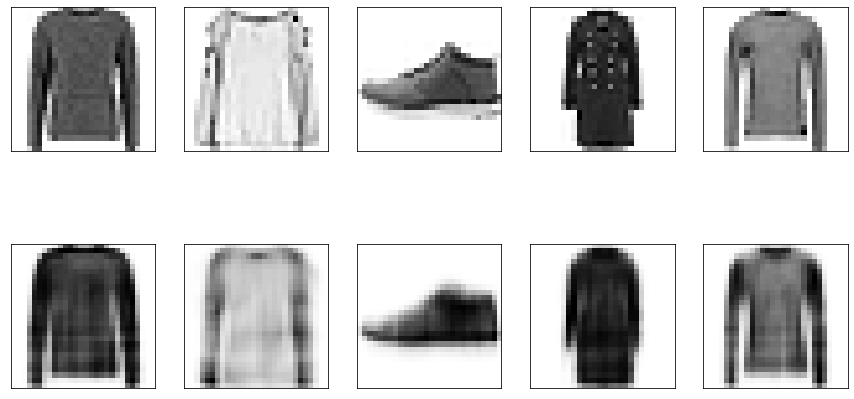

In [18]:
compare_samples(x_test, x_test_pred)

## let's consider the sparsity of an embedding 
### how big are the embeddings on avearge and how many zeros do the embeddings contain on average

In [19]:
embedded_imgs.shape

(10000, 32)

In [20]:
# embedding for first image
embedded_imgs[0]

array([ 3.118853  , 10.628472  ,  3.5401087 ,  0.        ,  2.4883986 ,
        2.6886077 ,  5.206223  ,  0.        ,  2.8169792 ,  5.130616  ,
        6.085864  ,  8.645245  ,  7.71109   ,  6.4787693 ,  2.197678  ,
        3.2074373 ,  9.066401  ,  6.557599  ,  8.101746  ,  8.281113  ,
        4.278743  ,  4.043586  ,  8.712522  ,  4.851785  ,  2.3702738 ,
        3.861825  ,  5.9619994 ,  1.800088  ,  3.364902  ,  7.1576095 ,
        0.87442195,  3.4615116 ], dtype=float32)

In [21]:
tf.reduce_mean(embedded_imgs)

<tf.Tensor: shape=(), dtype=float32, numpy=4.580473>

In [22]:
# how many zeros do the embeddings contain on average
tf.reduce_mean(32 - tf.math.count_nonzero(embedded_imgs, axis=1))

<tf.Tensor: shape=(), dtype=int64, numpy=3>

## Exercise

Experiment with
* the size of the embedding
* MSE as a loss function
* mnist digits dataset instead of fashin mninst

# STOP HERE

## Adding sparsity

In [23]:
from tensorflow.keras import regularizers

encoding_dim = 32

input_img = Input(shape=(image_size,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(1e-3))(input_img)
decoded = Dense(784, activation='sigmoid', name='decoder')(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
decoder (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow import keras

@tf.function
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [25]:
%%time 

BATCH_SIZE = 256
EPOCHS = 100

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[rounded_accuracy])

# we expect 0.09 for mninst and around 0.28 for fahshin mnist
history = autoencoder.fit(x = x_train,
                    y = x_train,
                    validation_data=(x_test, x_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 23us/sample - loss: 0.4825 - rounded_accuracy: 0.7910 - val_loss: 0.3974 - val_rounded_accuracy: 0.8592
Epoch 2/100
60000/60000 [==============================] - 1s 17us/sample - loss: 0.3732 - rounded_accuracy: 0.8776 - val_loss: 0.3603 - val_rounded_accuracy: 0.8869
Epoch 3/100
60000/60000 [==============================] - 1s 17us/sample - loss: 0.3507 - rounded_accuracy: 0.8943 - val_loss: 0.3465 - val_rounded_accuracy: 0.8981
Epoch 4/100
60000/60000 [==============================] - 1s 17us/sample - loss: 0.3401 - rounded_accuracy: 0.9030 - val_loss: 0.3381 - val_rounded_accuracy: 0.9049
Epoch 5/100
60000/60000 [==============================] - 1s 16us/sample - loss: 0.3329 - rounded_accuracy: 0.9089 - val_loss: 0.3319 - val_rounded_accuracy: 0.9089
Epoch 6/100
60000/60000 [==============================] - 1s 16us/sample - loss: 0.3277 - rounded_accuracy: 0.9125 - va

In [0]:
encoder = Model(input_img, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.get_layer('decoder')
decoder = Model(encoded_input, decoder_layer(encoded_input))

embedded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(embedded_imgs)

numbers of zeros should go up, while average should go down

In [27]:
# embedding for first image
embedded_imgs[0]

array([0.        , 0.        , 0.56366605, 0.        , 0.        ,
       0.        , 1.124828  , 0.21305615, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02769717, 0.40225935, 0.22841448, 0.        ,
       0.16898635, 0.        , 0.88622963, 0.08432478, 0.12859356,
       0.78145057, 0.        , 0.        , 0.        , 0.        ,
       0.34104642, 0.        ], dtype=float32)

In [28]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(32 - tf.math.count_nonzero(embedded_imgs, axis=1))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.14778095>,
 <tf.Tensor: shape=(), dtype=int64, numpy=19>)

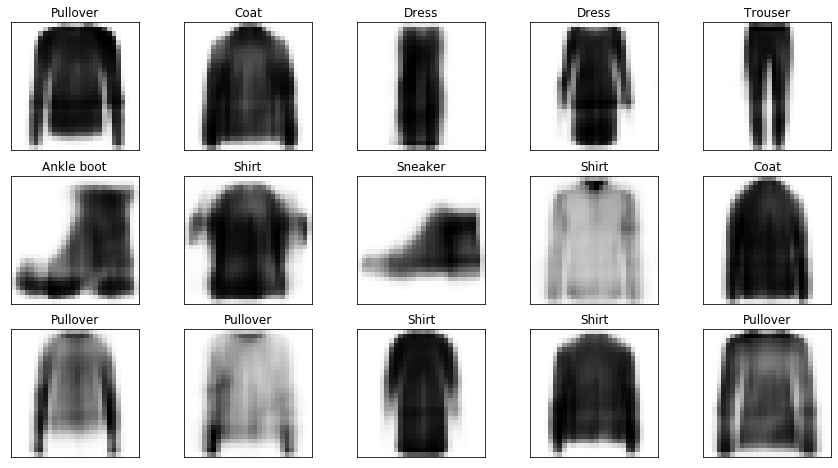

In [29]:
plot_samples(decoded_imgs, y_test, labels=fashion_mnist_labels)

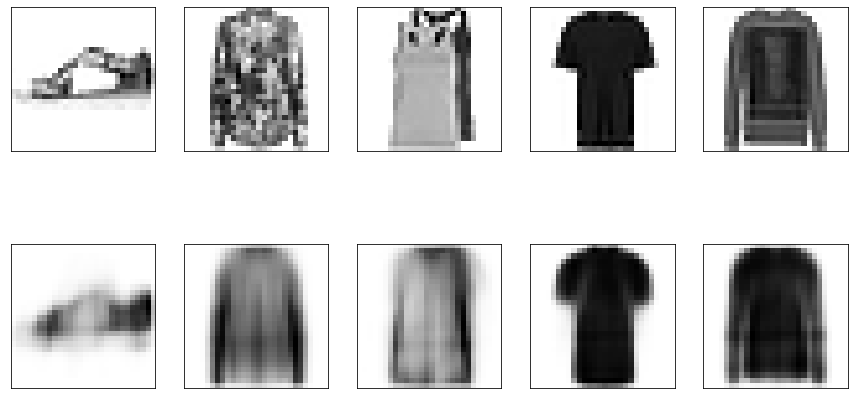

In [30]:
compare_samples(x_test, decoded_imgs)

## Deeper Autoencoder
https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [31]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [32]:
%%time

BATCH_SIZE = 256
EPOCHS = 20

encoding_dim = 32

stacked_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(x_res, y_res)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(encoding_dim, activation="relu", activity_regularizer=keras.regularizers.l1(5e-4)),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Input(shape=encoding_dim),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(image_size, activation="sigmoid"),
    keras.layers.Reshape((x_res, y_res))
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer='adam', metrics=[rounded_accuracy])
history = stacked_ae.fit(x_train, x_train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 26us/sample - loss: 0.3839 - rounded_accuracy: 0.8585 - val_loss: 0.3324 - val_rounded_accuracy: 0.9024
Epoch 2/20
60000/60000 [==============================] - 1s 18us/sample - loss: 0.3232 - rounded_accuracy: 0.9077 - val_loss: 0.3200 - val_rounded_accuracy: 0.9106
Epoch 3/20
60000/60000 [==============================] - 1s 18us/sample - loss: 0.3145 - rounded_accuracy: 0.9130 - val_loss: 0.3140 - val_rounded_accuracy: 0.9134
Epoch 4/20
60000/60000 [==============================] - 1s 18us/sample - loss: 0.3097 - rounded_accuracy: 0.9164 - val_loss: 0.3098 - val_rounded_accuracy: 0.9178
Epoch 5/20
60000/60000 [==============================] - 1s 18us/sample - loss: 0.3062 - rounded_accuracy: 0.9190 - val_loss: 0.3085 - val_rounded_accuracy: 0.9160
Epoch 6/20
60000/60000 [==============================] - 1s 18us/sample - loss: 0.3037 - rounded_accuracy: 0.9209 - val_loss

In [0]:
x_test_pred = stacked_ae.predict(x_test)

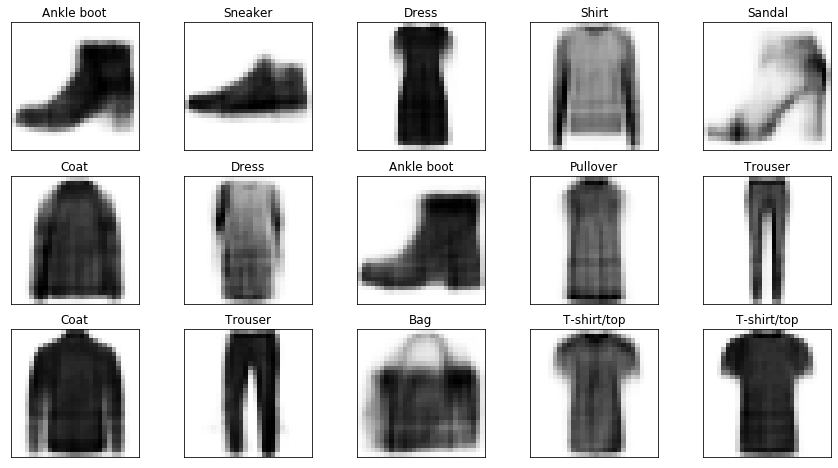

In [34]:
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)

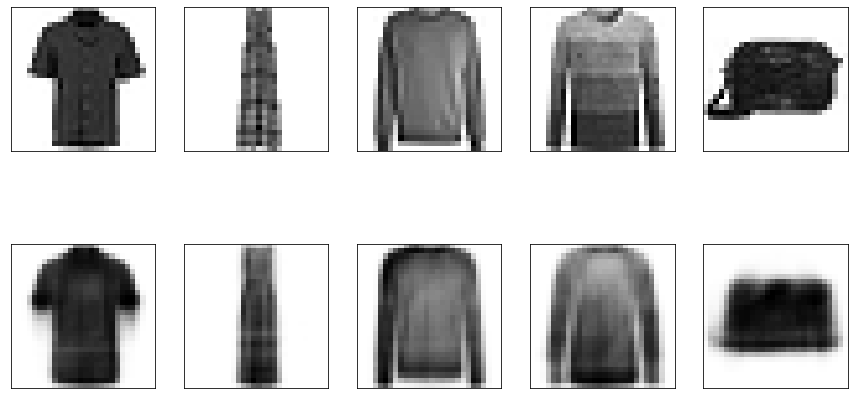

In [35]:
compare_samples(x_test, x_test_pred)

In [36]:
embedded_imgs = stacked_encoder.predict(x_test)
embedded_imgs.shape

(10000, 32)

In [37]:
embedded_imgs[0]

array([0.0000000e+00, 0.0000000e+00, 5.8313179e-01, 0.0000000e+00,
       1.4660731e-03, 0.0000000e+00, 0.0000000e+00, 1.7300434e-01,
       6.8156791e-01, 0.0000000e+00, 1.9641731e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 2.3402328e+00, 0.0000000e+00,
       2.5341287e-01, 1.6759646e-01, 7.0309423e-02, 0.0000000e+00,
       0.0000000e+00, 2.7824470e-01, 8.6764562e-01, 0.0000000e+00,
       1.4104161e+00, 0.0000000e+00, 2.7464226e-01, 0.0000000e+00,
       0.0000000e+00, 3.2626382e-01, 0.0000000e+00, 0.0000000e+00],
      dtype=float32)

In [38]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(32 - tf.math.count_nonzero(embedded_imgs, axis=1))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.2675004>,
 <tf.Tensor: shape=(), dtype=int64, numpy=18>)

## Looking at our embeddings

In [0]:
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
# https://umap-learn.readthedocs.io/en/latest/how_umap_works.html
import umap

In [40]:
%%time

# https://umap-learn.readthedocs.io/en/latest/parameters.html
reducer = umap.UMAP(
#     n_neighbors=5, 
    random_state=42)
embeddings_2d = reducer.fit_transform(embedded_imgs)

CPU times: user 30 s, sys: 236 ms, total: 30.2 s
Wall time: 29.7 s


In [41]:
embeddings_2d.shape

(10000, 2)

In [42]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_2d = scaler.fit_transform(embeddings_2d)
embeddings_2d.shape

(10000, 2)

(-1.8618885926979658,
 1.345396583535063,
 -2.5809201927393914,
 1.7927458019465445)

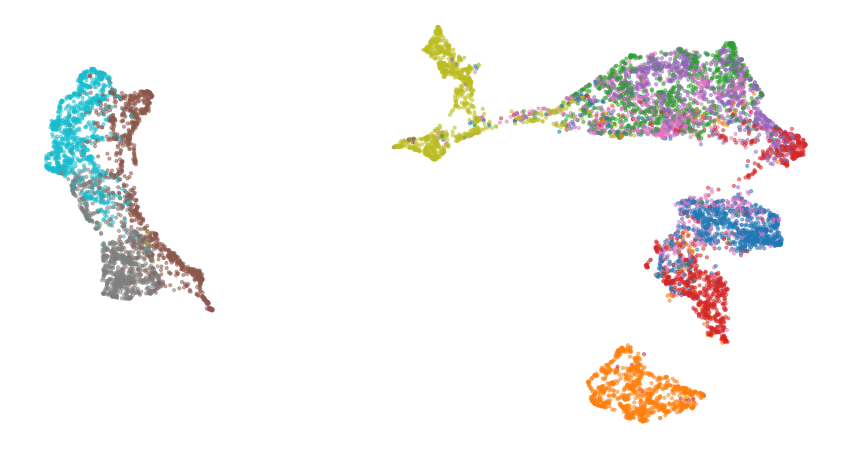

In [43]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap="tab10", alpha=0.5)
plt.axis("off")

(-1.8618885926979658,
 1.345396583535063,
 -2.5809201927393914,
 1.7927458019465445)

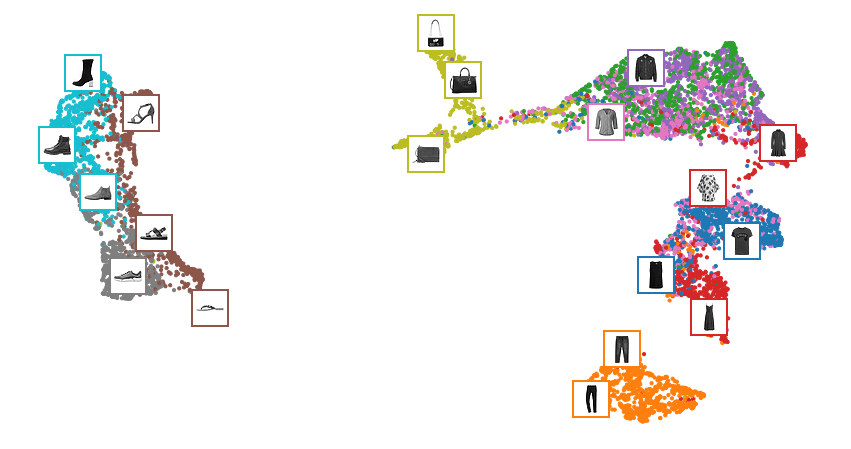

In [44]:
# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
cmap = plt.cm.tab10
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embeddings_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.2: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")

## Using 2d embeddings directly without UMAP dimensionality reduction

In [130]:
%%time

BATCH_SIZE = 2048
EPOCHS = 100

encoding_dim = 2

stacked_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(x_res, y_res)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(encoding_dim, activation="relu",
                       activity_regularizer=keras.regularizers.l1(1e-5)
                      )
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Input(shape=encoding_dim),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(image_size, activation="sigmoid"),
    keras.layers.Reshape((x_res, y_res))
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer='adam', metrics=[rounded_accuracy])
history = stacked_ae.fit(x_train, x_train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 1s 15us/sample - loss: 0.5478 - rounded_accuracy: 0.6921 - val_loss: 0.4713 - val_rounded_accuracy: 0.7354
Epoch 2/100
60000/60000 [==============================] - 0s 6us/sample - loss: 0.4553 - rounded_accuracy: 0.7552 - val_loss: 0.4473 - val_rounded_accuracy: 0.7678
Epoch 3/100
60000/60000 [==============================] - 0s 6us/sample - loss: 0.4433 - rounded_accuracy: 0.7735 - val_loss: 0.4422 - val_rounded_accuracy: 0.7760
Epoch 4/100
60000/60000 [==============================] - 0s 6us/sample - loss: 0.4389 - rounded_accuracy: 0.7811 - val_loss: 0.4376 - val_rounded_accuracy: 0.7848
Epoch 5/100
60000/60000 [==============================] - 0s 6us/sample - loss: 0.4322 - rounded_accuracy: 0.7938 - val_loss: 0.4273 - val_rounded_accuracy: 0.8035
Epoch 6/100
60000/60000 [==============================] - 0s 6us/sample - loss: 0.4191 - rounded_accuracy: 0.8139 - val_los

In [0]:
x_test_pred = stacked_ae.predict(x_test)

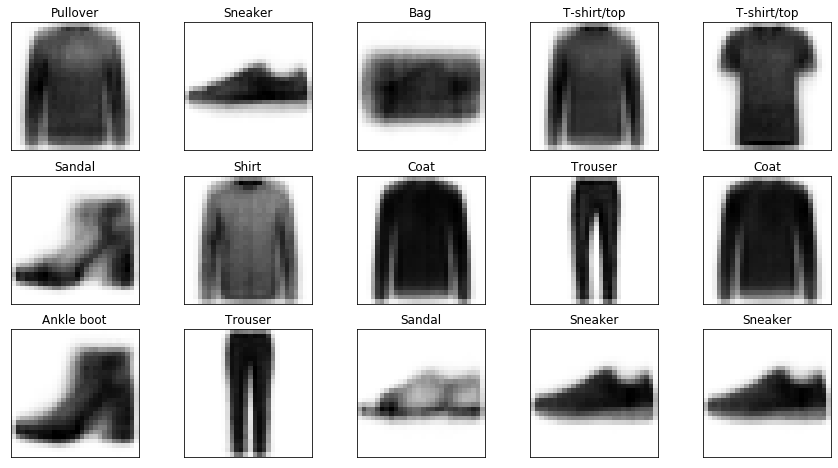

In [132]:
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)

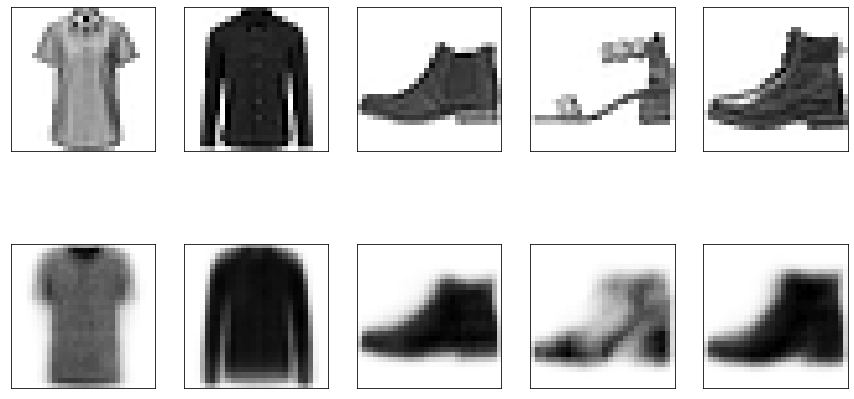

In [133]:
compare_samples(x_test, x_test_pred)

In [134]:
embedded_imgs = stacked_encoder.predict(x_test)
embedded_imgs.shape

(10000, 2)

In [135]:
embedded_imgs[0]

array([9.230425, 9.087981], dtype=float32)

In [136]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(2.0 - tf.cast(tf.math.count_nonzero(embedded_imgs, axis=1), tf.float32))

(<tf.Tensor: shape=(), dtype=float32, numpy=13.048464>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0181>)

In [0]:
embeddings_2d = embedded_imgs

In [138]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_2d = scaler.fit_transform(embeddings_2d)
embeddings_2d.shape

(10000, 2)

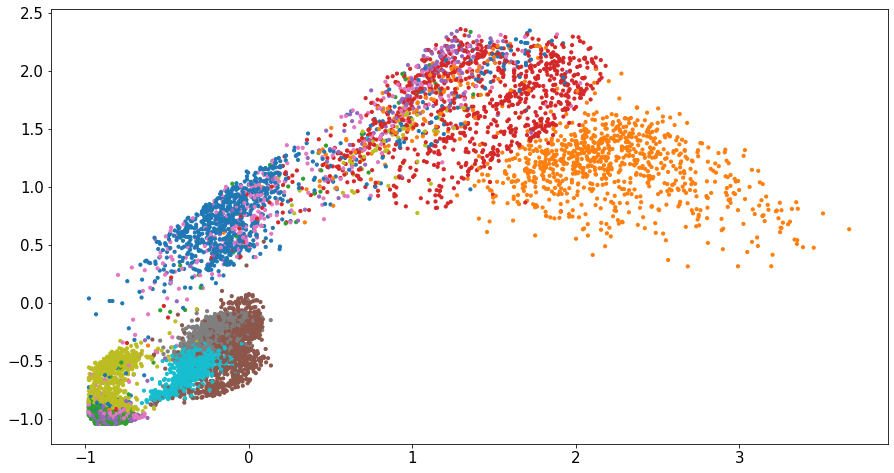

In [139]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)

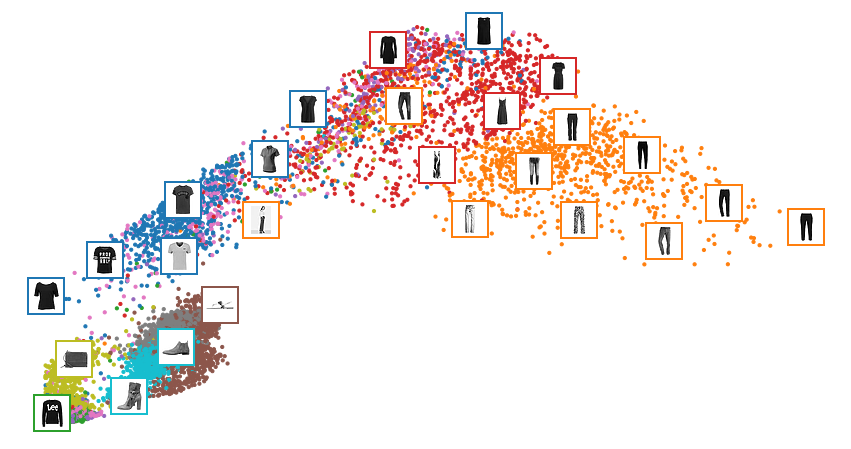

In [140]:
min_dist = 0.2

# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
cmap = plt.cm.tab10
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embeddings_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > min_dist: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off");

## Convolutional Autoencoders

In [2]:
!ls -l

total 2016
-rw-r--r-- 1 root root 2058632 Dec 29 13:58 mnist-classifier.h5
drwxr-xr-x 1 root root    4096 Dec 18 16:52 sample_data
